<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Vespa 🤝 ColPali: Efficient Document Retrieval with Vision Language Models

For a simpler example of using ColPali, where we use one Vespa document = One PDF page, see [simplified-retrieval-with-colpali](https://pyvespa.readthedocs.io/en/latest/examples/simplified-retrieval-with-colpali-vlm_Vespa-cloud.html).

This notebook demonstrates how to represent [ColPali](https://huggingface.co/vidore/colpali) in Vespa. ColPali is a powerful visual language model that can generate embeddings for images and text. 
In this notebook, we will use ColPali to generate embeddings for images of PDF _pages_ and store them in Vespa. 
We will also store the base64 encoded image of the PDF page and some meta data like title and url. We will then demonstrate how to retrieve the pdf pages using the embeddings generated by ColPali.

[ColPali: Efficient Document Retrieval with Vision Language Models Manuel Faysse, Hugues Sibille, Tony Wu, Bilel Omrani, Gautier Viaud, Céline Hudelot, Pierre Colombo](https://arxiv.org/abs/2407.01449v2)

ColPali is a combination of [ColBERT](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/) 
and [PaliGemma](https://huggingface.co/blog/paligemma):

>ColPali is enabled by the latest advances in Vision Language Models, notably the PaliGemma model from the Google Zürich team, and leverages multi-vector retrieval through late interaction mechanisms as proposed in ColBERT by Omar Khattab.

Quote from [ColPali: Efficient Document Retrieval with Vision Language Models 👀](https://huggingface.co/blog/manu/colpali)

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/rvRCudun_70rI08NHuU3_.jpeg)

The ColPali model achieves remarkable retrieval performance on the ViDoRe (Visual Document Retrieval) Benchmark. Beating complex pipelines with a single model.

![ColPali Results](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/J4VzBZpT-YlyGGEmXCHNQ.png)

The TLDR of this notebook:

- Generate an image per PDF page using [pdf2image](https://pypi.org/project/pdf2image/) 
and also extract the text using [pypdf](https://pypdf.readthedocs.io/en/stable/user/extract-text.html). 
- For each page image, use ColPali to obtain the visual multi-vector embeddings

Then we store colbert embeddings in Vespa and use the [long-context variant](https://blog.vespa.ai/announcing-long-context-colbert-in-vespa/)
where we represent the colbert embeddings per document with the tensor `tensor(page{}, patch{}, v[128])`. This enables 
us to use the PDF as the document (retrievable unit), storing the page embeddings in the same document. 

The upside of this is that we do not need to duplicate document level meta data like title, url, etc. But, the downside is that 
we cannot retrieve using the ColPali embeddings directly, but need to use the extracted text for retrieval. The ColPali embeddings are only used for reranking the results. 

For a simpler example where we use one vespa document = One PDF page, see [simplified-retrieval-with-colpali](https://pyvespa.readthedocs.io/en/latest/examples/simplified-retrieval-with-colpali-vlm_Vespa-cloud.html).

Consider following the [ColQWen2](https://pyvespa.readthedocs.io/en/latest/examples/pdf-retrieval-with-ColQwen2-vlm_Vespa-cloud.html) notebook instead as it
use a better model with improved performance (Both accuracy and speed).

We also store the base64 encoded image, and page meta data like title and url so that we can display it in the result page, but also
use it for RAG with powerful LLMs with vision capabilities. 

At query time, we retrieve using [BM25](https://docs.vespa.ai/en/reference/bm25.html) over all the text from all pages, 
then use the ColPali embeddings to rerank the results using the max page score. 

Let us get started. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/examples/colpali-document-retrieval-vision-language-models-cloud.ipynb)


Install dependencies: 

Note that the python pdf2image package requires poppler-utils, see other installation options [here](https://pdf2image.readthedocs.io/en/latest/installation.html#installing-poppler).

Install dependencies: 

In [1]:
#!sudo apt-get install poppler-utils -y

Install python packages 

In [2]:
#!pip3 install colpali-engine==0.3.1 vidore_benchmark==4.0.0 pdf2image google-generativeai pypdf==5.0.1 pyvespa vespacli requests

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from io import BytesIO

from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from vidore_benchmark.utils.image_utils import scale_image, get_base64_image

/Users/thomas/Repos/sample-apps/visual-retrieval-colpali/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model

This requires that the HF_TOKEN environment variable is set as the underlaying PaliGemma model is hosted on Hugging Face 
and has a [restricive licence](https://ai.google.dev/gemma/terms) that requires authentication.

Choose the right device to run the model.

In [4]:
device = get_torch_device("auto")
if device == "cuda":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

In [5]:
model_name = "vidore/colpali-v1.2"
model = ColPali.from_pretrained(model_name, torch_dtype=dtype, device_map=device).eval()
processor = ColPaliProcessor.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


## Working with pdfs

We need to convert a PDF to an array of images. One image per page. 
We will use pdf2image for this. Secondary, we also extract the text content of the pdf using pypdf. 

NOTE: This step requires that you have `poppler` installed on your system. Read more in [pdf2image](https://pdf2image.readthedocs.io/en/latest/installation.html) docs.

In [6]:
import requests
from pdf2image import convert_from_path
from pypdf import PdfReader


def download_pdf(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        raise Exception(f"Failed to download PDF: Status code {response.status_code}")


def get_pdf_images(pdf_url):
    # Download the PDF
    pdf_file = download_pdf(pdf_url)
    # Save the PDF temporarily to disk (pdf2image requires a file path)
    with open("temp.pdf", "wb") as f:
        f.write(pdf_file.read())
    reader = PdfReader("temp.pdf")
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path("temp.pdf")
    assert len(images) == len(page_texts)
    return (images, page_texts)

We define a few sample PDFs to work with. 

In [7]:
sample_pdfs = [
    {
        "title": "ColBERTv2: Effective and Efficient Retrieval via Lightweight Late Interaction",
        "url": "https://arxiv.org/pdf/2112.01488.pdf",
        "authors": "Keshav Santhanam, Omar Khattab, Jon Saad-Falcon, Christopher Potts, Matei Zaharia",
    },
    {
        "title": "ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT",
        "url": "https://arxiv.org/pdf/2004.12832.pdf",
        "authors": "Omar Khattab, Matei Zaharia",
    },
]

Now we can convert the PDFs to images and also extract the text content.

In [8]:
for pdf in sample_pdfs:
    page_images, page_texts = get_pdf_images(pdf["url"])
    pdf["images"] = page_images
    pdf["texts"] = page_texts

Let us look at the extracted image of the first PDF page. This is the input to ColPali. 

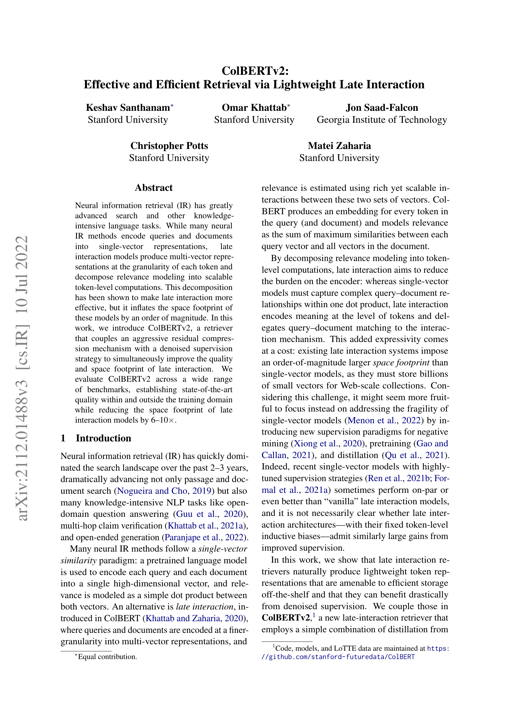

In [9]:
from IPython.display import display

display(scale_image(sample_pdfs[0]["images"][0], 720))

Now we use the ColPali model to generate embeddings for the images.

In [10]:
for pdf in sample_pdfs:
    page_embeddings = []
    dataloader = DataLoader(
        pdf["images"],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x),
    )
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
            embeddings_doc = model(**batch_doc)
            # also handle if running on GPU
            if model.device == "cuda":
                embeddings_doc = embeddings_doc.float()
            page_embeddings.extend(list(torch.unbind(embeddings_doc.cpu())))
    pdf["embeddings"] = page_embeddings

100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


Now we are done with the document side embeddings, we now convert the custom dict to 
[Vespa JSON feed](https://docs.vespa.ai/en/reference/document-json-format.html) format. 

 
We use binarization of the vector embeddings to reduce their size. Read
more about binarization of multi-vector representations in the [colbert blog post](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/). This maps 128 dimensional floats to 128 bits, or 16 bytes per vector. Reducing
the size by 32x.

In [11]:
import numpy as np
from typing import Dict, List
from binascii import hexlify


def binarize_token_vectors_hex(vectors: List[torch.Tensor]) -> Dict[str, str]:
    vespa_tensor = list()
    for page_id in range(0, len(vectors)):
        page_vector = vectors[page_id]
        binarized_token_vectors = np.packbits(
            np.where(page_vector > 0, 1, 0), axis=1
        ).astype(np.int8)
        for patch_index in range(0, len(page_vector)):
            values = str(
                hexlify(binarized_token_vectors[patch_index].tobytes()), "utf-8"
            )
            if (
                values == "00000000000000000000000000000000"
            ):  # skip empty vectors due to padding of batch
                continue
            vespa_tensor_cell = {
                "address": {"page": page_id, "patch": patch_index},
                "values": values,
            }
            vespa_tensor.append(vespa_tensor_cell)

    return vespa_tensor

Iterate over the sample and create the Vespa JSON feed format, including the base64 encoded page images.

In [12]:
vespa_feed = []
for idx, pdf in enumerate(sample_pdfs):
    images_base_64 = []
    for image in pdf["images"]:
        images_base_64.append(get_base64_image(image, add_url_prefix=False))
    pdf["images_base_64"] = images_base_64
    doc = {
        "fields": {
            "url": pdf["url"],
            "title": pdf["title"],
            "images": pdf["images_base_64"],
            "texts": pdf["texts"],  # Array of text per page
            "colbert": {  # Colbert embeddings per page
                "blocks": binarize_token_vectors_hex(pdf["embeddings"])
            },
        }
    }
    vespa_feed.append(doc)

In [13]:
vespa_feed[0]["fields"]["colbert"]["blocks"][0:5]

[{'address': {'page': 0, 'patch': 0},
  'values': '270396e21bde8b9266dfa096cf3307e4'},
 {'address': {'page': 0, 'patch': 1},
  'values': '67c392e28bfa898264dfa81ecf3303c4'},
 {'address': {'page': 0, 'patch': 2},
  'values': '238790aa93fa8b9264dfa816ce3163cc'},
 {'address': {'page': 0, 'patch': 3},
  'values': '67c394aa0bfa899264ffa83ecf3323cc'},
 {'address': {'page': 0, 'patch': 4},
  'values': '6e891332c3f2e0b624b62a71c3b02224'}]

Above is the feed format for mixed tensors with more than one mapped dimension, see [details](https://docs.vespa.ai/en/reference/constant-tensor-json-format.html#mixed-tensors). We have the `page` and `patch` dimensions and for each combination with have a binary representation of the 128 dimensional embeddings, packed into 16 bytes.

For each page image, we have 1030 patches, each with a 128 dimensional embedding.

## Configure Vespa
[PyVespa](https://pyvespa.readthedocs.io/en/latest/) helps us build the [Vespa application package](https://docs.vespa.ai/en/application-packages.html).
A Vespa application package consists of configuration files, schemas, models, and code (plugins).

First, we define a [Vespa schema](https://docs.vespa.ai/en/schemas.html) with the fields we want to store and their type.

In [14]:
from vespa.package import Schema, Document, Field, FieldSet

colbert_schema = Schema(
    name="doc",
    document=Document(
        fields=[
            Field(name="url", type="string", indexing=["summary"]),
            Field(
                name="title",
                type="string",
                indexing=["summary", "index"],
                index="enable-bm25",
            ),
            Field(
                name="texts",
                type="array<string>",
                indexing=["index"],
                index="enable-bm25",
            ),
            Field(
                name="images",
                type="array<string>",
                indexing=["summary"],
            ),
            Field(
                name="colbert",
                type="tensor<int8>(page{}, patch{}, v[16])",
                indexing=["attribute"],
            ),
        ]
    ),
    fieldsets=[FieldSet(name="default", fields=["title", "texts"])],
)

Notice the `colbert` field is a tensor field with the type `tensor(page{}, patch{}, v[128])`. This is the field that will store the embeddings generated by ColPali. This is an example of a mixed tensor where we combine two mapped (sparse) dimensions with one dense. 

Read more in [Tensor guide](https://docs.vespa.ai/en/tensor-user-guide.html). We also enable [BM25](https://docs.vespa.ai/en/reference/bm25.html) for the `title` and `texts` fields. 

Create the Vespa [application package](https://docs.vespa.ai/en/application-packages): 

In [15]:
from vespa.package import ApplicationPackage

vespa_app_name = "visionrag"
vespa_application_package = ApplicationPackage(
    name=vespa_app_name, schema=[colbert_schema]
)

Now we define how we want to rank the pages. We use BM25 for the text and late interaction with Max Sim for the image embeddings. 
This means that we retrieve using the text representations to find relevant PDF documents, then we use the ColPALI embeddings to rerank the pages within the document using the max of the page scores.

 We also return all the page level scores using `match-features`,  so that we can
render multiple scoring pages in the search result. 

As LLMs gets longer context windows, we can input more than a single page per PDF. 

In [16]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

colbert_profile = RankProfile(
    name="default",
    inputs=[("query(qt)", "tensor<float>(querytoken{}, v[128])")],
    functions=[
        Function(
            name="max_sim_per_page",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(colbert)) , v
                        ),
                        max, patch
                    ),
                    querytoken
                )
            """,
        ),
        Function(name="max_sim", expression="reduce(max_sim_per_page, max, page)"),
        Function(name="bm25_score", expression="bm25(title) + bm25(texts)"),
    ],
    first_phase=FirstPhaseRanking(expression="bm25_score"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=10),
    match_features=["max_sim_per_page", "bm25_score"],
)
colbert_schema.add_rank_profile(colbert_profile)

Validate that certificates are ok and deploy the application to Vespa Cloud.

### Deploy to Vespa Cloud

With the configured application, we can deploy it to [Vespa Cloud](https://cloud.vespa.ai/en/).

`PyVespa` supports deploying apps to the [development zone](https://cloud.vespa.ai/en/reference/environments#dev-and-perf).

> Note: Deployments to dev and perf expire after 7 days of inactivity, i.e., 7 days after running deploy. This applies to all plans, not only the Free Trial. Use the Vespa Console to extend the expiry period, or redeploy the application to add 7 more days.


In [17]:
from vespa.deployment import VespaCloud
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"

key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=vespa_app_name,
    key_content=key,  # Key is only used for CI/CD testing of this notebook. Can be removed if logging in interactively
    application_package=vespa_application_package,
)

Setting application...
Running: vespa config set application vespa-team.visionrag
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.


Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes 2 minutes until the endpoint is up.


In [18]:
from vespa.application import Vespa

app: Vespa = vespa_cloud.deploy()

Deployment started in run 64 of dev-aws-us-east-1c for vespa-team.visionrag. This may take a few minutes the first time.
INFO    [09:00:30]  Deploying platform version 8.450.33 and application dev build 39 for dev-aws-us-east-1c of default ...
INFO    [09:00:30]  Using CA signed certificate version 3
INFO    [09:00:30]  Using 1 nodes in container cluster 'visionrag_container'
INFO    [09:00:34]  Session 326496 for tenant 'vespa-team' prepared and activated.
INFO    [09:00:34]  ######## Details for all nodes ########
INFO    [09:00:34]  h97488a.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [09:00:34]  --- platform vespa/cloud-tenant-rhel8:8.450.33
INFO    [09:00:34]  --- storagenode on port 19102 has config generation 326496, wanted is 326496
INFO    [09:00:34]  --- searchnode on port 19107 has config generation 326496, wanted is 326496
INFO    [09:00:34]  --- distributor on port 19111 has config generation 326495, wanted is 326496
INFO    [09:00:34]  --- metricsproxy-co

This example uses the synchronous feed method and feeds one document at a time. For larger datasets, consider using the asynchronous feed method.

In [19]:
from vespa.io import VespaResponse

with app.syncio() as sync:
    for operation in vespa_feed:
        fields = operation["fields"]
        response: VespaResponse = sync.feed_data_point(
            data_id=fields["url"], fields=fields, schema="doc"
        )
        if not response.is_successful():
            print(response.json())

## Querying Vespa

Ok, so now we have indexed the PDF pages in Vespa. Let us now obtain ColPali embeddings for a text query and 
use it to match against the indexed PDF pages.

Our demo query: 

_Composition of the Lotte Benchmark_

In [20]:
queries = ["Composition of the LoTTE benchmark"]

Obtain the query embeddings using the ColPali model

In [ ]:
dataloader = DataLoader(
    queries,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: processor.process_queries(x),
)
qs = []
for batch_query in dataloader:
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
        # also handle if running on GPU
        if model.device == "cuda":
            embeddings_query = embeddings_query.float()
        qs.extend(list(torch.unbind(embeddings_query.cpu())))

NameError: name 'autocast' is not defined

A simple routine to format the ColPali multi-vector emebeddings to a format that can be used in Vespa.
See [querying with tensors](https://docs.vespa.ai/en/tensor-user-guide.html#querying-with-tensors) for more details. 

In [ ]:
def float_query_token_vectors(vectors: torch.Tensor) -> Dict[str, List[float]]:
    vespa_token_dict = dict()
    for index in range(0, len(vectors)):
        vespa_token_dict[index] = vectors[index].tolist()
    return vespa_token_dict

We create a simple routine to display the results. 

Notice that each hit is a PDF document. Within a PDF document
we have multiple pages and we have the MaxSim score for each page. 

The PDF documents are ranked by the maximum page score. But, we have access to all the page level scores and 
below we display the top 2-pages for each PDF document. We convert the base64 encoded image to a PIL image 
for rendering. We could also render the extracted text, but we skip that for now.

In [ ]:
from IPython.display import display, HTML
import base64


def display_query_results(query, response):
    """
    Displays the query result, including the two best matching pages per matched pdf.
    """
    html_content = f"<h3>Query text: {query}</h3>"

    for i, hit in enumerate(response.hits[:2]):  # Adjust to show more hits if needed
        title = hit["fields"]["title"]
        url = hit["fields"]["url"]
        match_scores = hit["fields"]["matchfeatures"]["max_sim_per_page"]
        images = hit["fields"]["images"]

        html_content += f"<h3>PDF Result {i + 1}</h3>"
        html_content += f'<p><strong>Title:</strong> <a href="{url}">{title}</a></p>'

        # Find the two best matching pages
        sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
        best_pages = sorted_pages[:2]

        for page, score in best_pages:
            page = int(page)
            image_data = base64.b64decode(images[page])
            image = Image.open(BytesIO(image_data))
            scaled_image = scale_image(image, 648)

            buffered = BytesIO()
            scaled_image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            html_content += f"<p><strong>Best Matching Page {page+1} for PDF document:</strong> with MaxSim score {score:.2f}</p>"
            html_content += (
                f'<img src="data:image/png;base64,{img_str}" style="max-width:100%;">'
            )

    display(HTML(html_content))

Query Vespa with a text query and display the results.


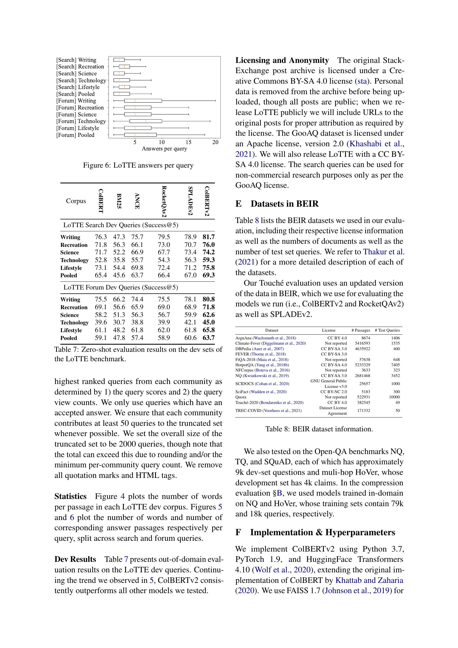
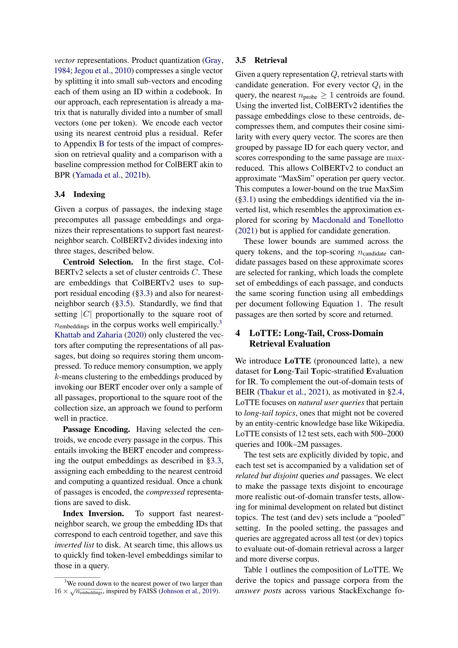
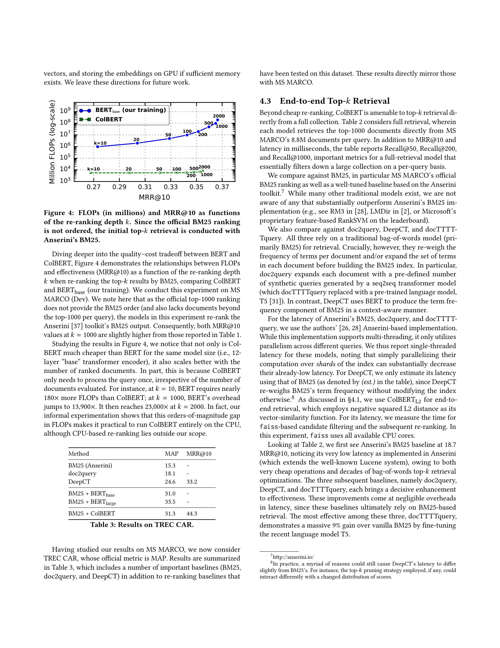
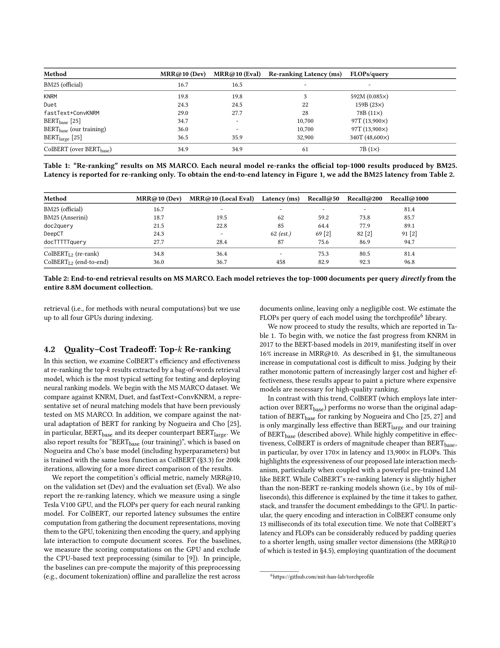

In [ ]:
from vespa.io import VespaQueryResponse

for idx, query in enumerate(queries):
    response: VespaQueryResponse = app.query(
        yql="select title,url,images from doc where userInput(@userQuery)",
        ranking="default",
        userQuery=query,
        timeout=2,
        hits=3,
        body={
            "presentation.format.tensors": "short-value",
            "input.query(qt)": float_query_token_vectors(qs[idx]),
        },
    )
    assert response.is_successful()
    display_query_results(query, response)

## RAG with LLMs with vision capabilities. 

Now we can use the top k documents to answer the question using a LLM with vision capabilities. 

This then becomes an end-to-end pipeline using vision capable language models, where we use ColPali visual embeddings for retrieval and
Gemini Flash to read the retrieved PDF pages and answer the question with that context. 

We will use the [Gemini Flash](https://deepmind.google/technologies/gemini/flash/) model for reading and answering. 

In the following, we input the best matching PDF _page_ image and the question. 


In [ ]:
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

Just extract the best page image from the first hit to demonstrate how to use the image with Gemini Flash to answer the question.

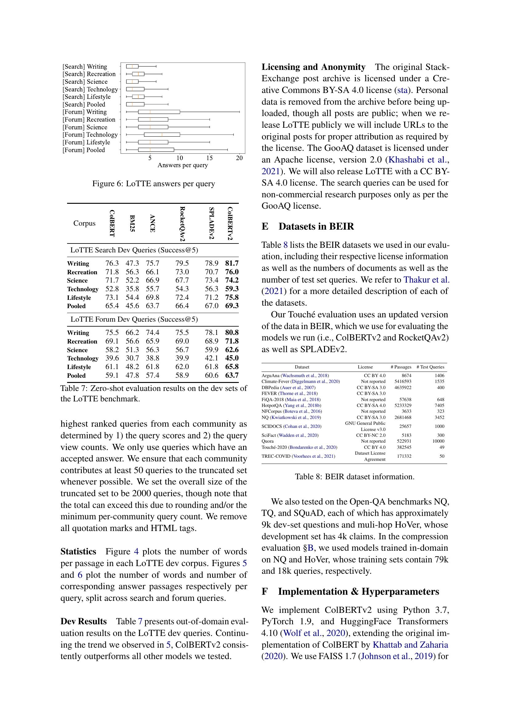

In [ ]:
best_hit = response.hits[0]
pdf_url = best_hit["fields"]["url"]
pdf_title = best_hit["fields"]["title"]
match_scores = best_hit["fields"]["matchfeatures"]["max_sim_per_page"]
images = best_hit["fields"]["images"]
sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
best_page, score = sorted_pages[0]
best_page = int(best_page)
image_data = base64.b64decode(images[best_page])
image = Image.open(BytesIO(image_data))
scaled_image = scale_image(image, 720)
display(scaled_image)

Initialize the Gemini Flash model and answer the question.

In [ ]:
model = genai.GenerativeModel(model_name="gemini-1.5-flash")
response = model.generate_content([queries[0], image])

Some formatting of the response from Gemini Flash. 

In [ ]:
from IPython.display import Markdown, display

markdown_text = response.candidates[0].content.parts[0].text
display(Markdown(markdown_text))

The LoTTE benchmark is composed of Stack Exchange posts from five communities: Writing, Recreation, Science, Technology, and Lifestyle.  The data is licensed under a Creative Commons BY-SA 4.0 license (with personal data removed).  The search queries included can be used for non-commercial research purposes only, under the GooAQ license.  The benchmark includes both search and forum queries.  The overall dataset size is approximately 2000 queries, though the total can exceed this due to rounding and minimum query counts per community.  All quotation marks and HTML tags are removed from the data.

## Summary 

In this notebook, we have demonstrated how to represent ColPali in Vespa. We have used ColPali to generate embeddings for images of pdf pages and stored them in Vespa. We have also stored the base64 encoded image of the pdf page and some meta data like title and url. We have then demonstrated how to retrieve the pdf pages using the embeddings generated by ColPali. We have also demonstrated how to use the top k documents to answer a question using a LLM with vision capabilities. 


## Cleanup

When this notebook is running in CI, we want to delete the application.

In [ ]:
if os.getenv("CI", "false") == "true":
    vespa_cloud.delete()